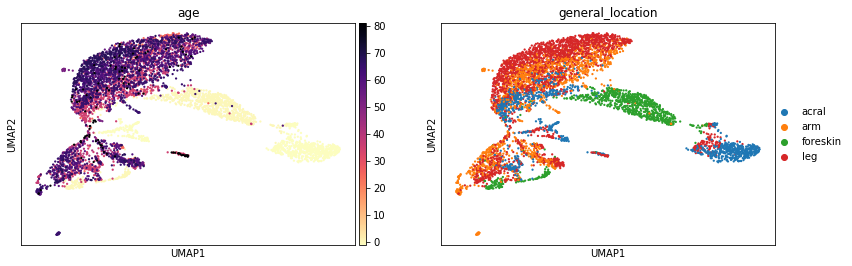

... storing 'noise_group' as categorical


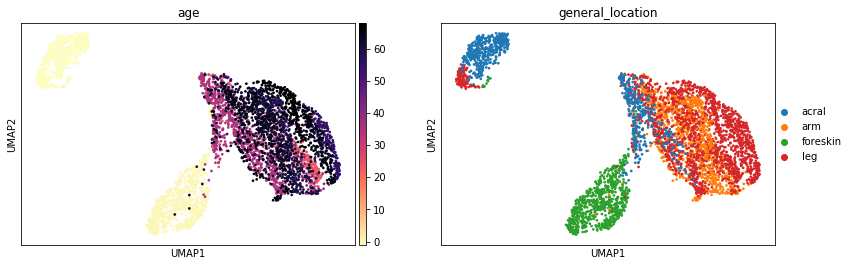

Completed


In [1]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT','raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


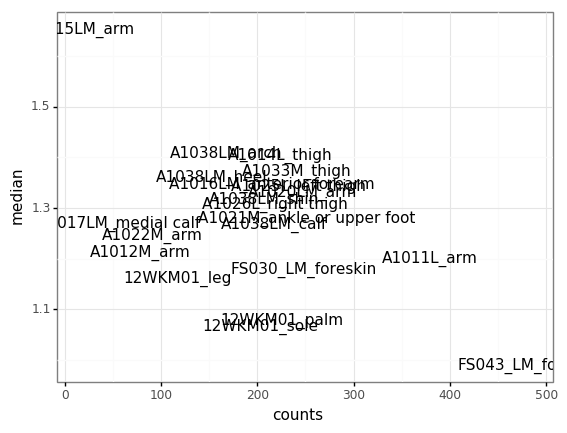

<ggplot: (-9223363292897707292)>
      median  counts          noise_group
5   1.652619      16          A1015LM_arm
0   1.268884      56  A1017LM_medial calf
1   1.212314      79           A1012M_arm
12  1.245365      91           A1022M_arm
18  1.161287     117          12WKM01_leg


In [2]:
# Determine correlation between cell-wise txn noise and cell counts
input_adata = adata_subset2
med_list = []
count_list = []
group_list = []
for x in set(input_adata.obs.noise_group):
    df_slice = input_adata[input_adata.obs.noise_group == x]
    count_list.append(len(df_slice))
    med_list.append(df_slice.obs.agg_noise.median())
    group_list.append(x)

plot_df = pd.DataFrame({'median':med_list,
                        'counts':count_list,
                        'noise_group':group_list})

print(ggplot(plot_df, aes('counts','median',label='noise_group'))
      +theme_bw()   
      +geom_text())

print(plot_df.sort_values('counts').head())

# (potentially) A1015LM, A1017LM, A1012M removed because of low cell count


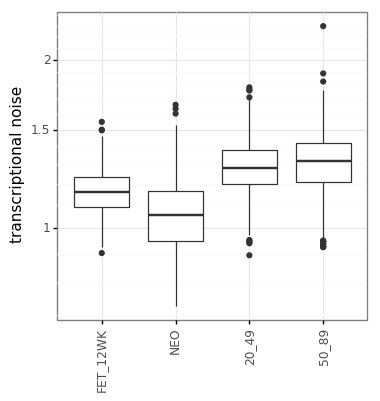

<ggplot: (8743947401273)>
Mann-Whitney U test: 681868.0 p-value: 9.07268649653348e-07


In [12]:
# cell-wise transcription noise vs grouping
input_adata = adata_subset2 
# remove A1015LM
input_adata = input_adata[input_adata.obs.patient != 'A1015LM']
groupby = 'age_group'
plot_df = (input_adata
           .obs
           .loc[[x != 'acral' for x in input_adata.obs.general_location], ['agg_noise', groupby]]) # remove acral 
plot_df = pd.melt(plot_df, id_vars=groupby)

# (if necessary) rank patients by age
if groupby == 'patient':
    cat_order = (input_adata.obs
                 .loc[:,['age','patient']]
                 .drop_duplicates()
                 .sort_values('age')
                 .patient.values.tolist())
    cat_order = [x for x in cat_order if x in list(set(plot_df.patient))]
    plot_df['patient'] = plot_df['patient'].astype(str).astype(CategoricalDtype(cat_order, ordered=True))

# plot
plotnine.options.figure_size=(4,4)
print(ggplot(plot_df)
         +theme_bw()
         +theme(axis_text_x=element_text(angle=90))
         +geom_boxplot(aes(groupby,'value'))
         +labs(y='transcriptional noise',x='')
         +scale_y_log10()
     )

## compute Mann-whitney u-test
group_vec1 = plot_df[plot_df[groupby] == '20_49']['value'].dropna().tolist()
group_vec2 = plot_df[plot_df[groupby] == '50_89']['value'].dropna().tolist()
stat, pval = stats.mannwhitneyu(group_vec1, group_vec2)
print('Mann-Whitney U test:', stat, 'p-value:', pval )


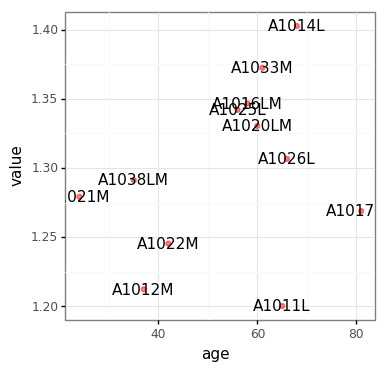

<ggplot: (-9223363292934784382)>
R2:  0.09439457612082731 p-value 0.33134242441587114


In [13]:
# plot age vs median txn noise
input_adata = adata_subset2
# remove A1015LM
input_adata = input_adata[input_adata.obs.patient != 'A1015LM']
# only adults
input_adata = input_adata[input_adata.obs.age > 0]
groupby = ['age','patient']
plot_df = (input_adata
           .obs
           .loc[[x != 'acral' for x in input_adata.obs.general_location], ['agg_noise'] + groupby]) # remove acral 
plot_df = pd.melt(plot_df, id_vars=groupby)
plot_df = pd.DataFrame(plot_df.groupby(groupby)['value'].median()).reset_index()

print(ggplot(plot_df, aes('age','value'))
      +theme_bw()
      +geom_point(alpha = 0.5, color ='red')
      +geom_text(aes(label='patient')))

r,pval = pearsonr(plot_df.age.values.tolist(), 
         plot_df['value'].values.tolist())
print('R2: ', r**2, 'p-value', pval)


... storing 'noise_group' as categorical


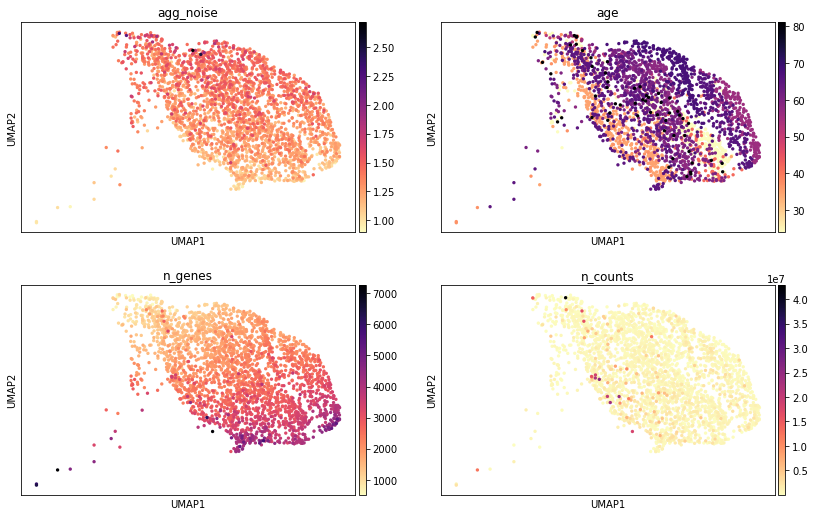

In [14]:
# correlate gene expression with noise metric

input_adata = adata_subset2
# remove acral and limit to only adults
input_adata = input_adata[[x > 0 and y != 'acral' for x,y in zip(input_adata.obs.age, input_adata.obs.general_location)]]
cat, gene_df = prepare_dataframe(input_adata,
                            input_adata.var_names,
                            'age_bin')
gene_df['agg_noise'] = input_adata.obs.agg_noise.values.tolist()
gene_df['n_genes'] = input_adata.obs.n_genes.values.tolist()
sc.pl.umap(input_adata, color = ['agg_noise', 'age', 'n_genes', 'n_counts'], 
           cmap = 'magma_r',
           ncols = 2 
          )


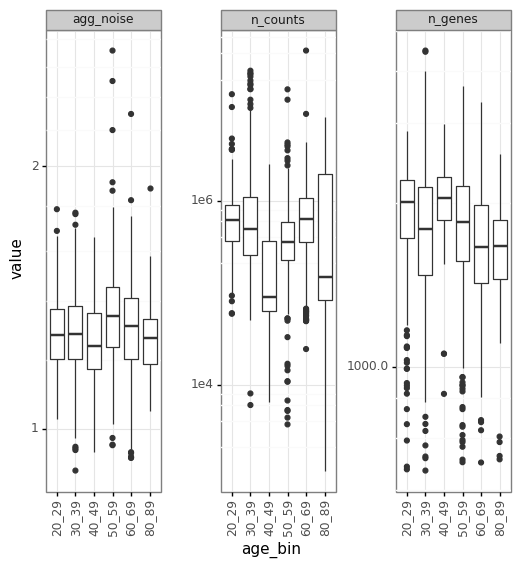

<ggplot: (-9223363292906577916)>
Spearmans rho: noise vs n_genes
SpearmanrResult(correlation=-0.5569830272967444, pvalue=1.392706562417448e-218)


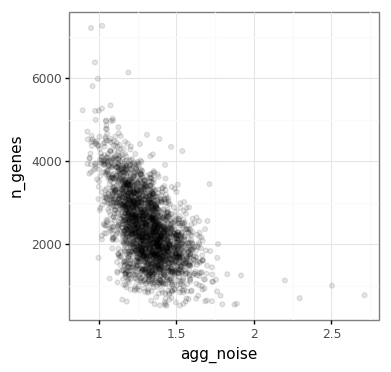

<ggplot: (-9223363292934778750)>
Spearmans rho: noise vs n_counts
SpearmanrResult(correlation=-0.25198903222105806, pvalue=3.774151363374099e-40)


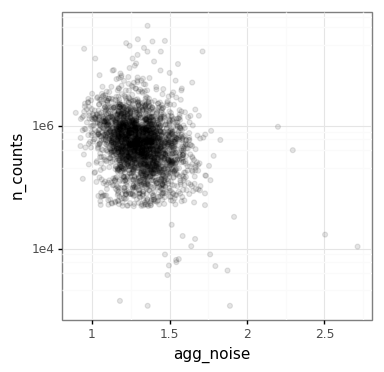

<ggplot: (-9223363292934751740)>


In [15]:
# summary of noise vs cell quality metrics

n_genes_df = pd.DataFrame({'agg_noise':input_adata.obs.agg_noise.tolist(),
                           'age_group':input_adata.obs.age_group.values.tolist(),
                           'age_bin':input_adata.obs.age_bin.values.tolist(),
                           'n_genes':input_adata.obs.n_genes.values.tolist(),
                           'n_counts':input_adata.obs.n_counts.values.tolist()})
plot_df = pd.melt(n_genes_df, id_vars = ['age_group','age_bin'])

plotnine.options.figure_size = (6,6)
print(ggplot(plot_df)
     +theme_bw()
     +theme(panel_spacing=0.6,
            axis_text_x = element_text(angle = 90))
     +geom_boxplot(aes('age_bin', 'value'))
     +facet_wrap('~variable', scales = 'free')
     +scale_y_log10()
     )

print('Spearmans rho: noise vs n_genes')
print(stats.spearmanr(n_genes_df['agg_noise'], n_genes_df['n_genes']))

plotnine.options.figure_size = (4,4)
print(ggplot(n_genes_df)
     +theme_bw()
     +geom_point(aes('agg_noise','n_genes'), alpha = 0.1)
     )

print('Spearmans rho: noise vs n_counts')
print(stats.spearmanr(n_genes_df['agg_noise'], n_genes_df['n_counts']))

plotnine.options.figure_size = (4,4)
print(ggplot(n_genes_df)
     +theme_bw()
     +geom_point(aes('agg_noise','n_counts'), alpha = 0.1)
     +scale_y_log10()
     )


In [16]:
# rank cells by noise or n_genes, then calculate rolling average expression for each ordering


import multiprocessing
# calculate difference in moving mean
def diff_mmean (args):
    gene, gene_df, window = args
    plot_df = pd.DataFrame()
    for feature in ['agg_noise','n_genes']:
        slice_df = (gene_df
               .loc[:,[gene] + [feature]]
                  )
        if feature == 'n_genes':
            ascending_order = False
        else:
            ascending_order = True
        slice_df = slice_df.sort_values(feature, ascending=ascending_order).rename(columns = {feature:'Mmean'})
        plot_df[feature] = slice_df[gene].rolling(window).mean().dropna().values
    stat, pval = stats.spearmanr(plot_df.agg_noise.values, plot_df.n_genes.values)
    return (stat, pval)

cat, gene_df = prepare_dataframe(input_adata,
                            input_adata.var_names,
                            'age_bin')
gene_df['agg_noise'] = input_adata.obs.agg_noise.values.tolist()
gene_df['n_genes'] = input_adata.obs.n_genes.values.tolist()

p = multiprocessing.Pool(processes=7)

try:
    results = p.map(diff_mmean, 
                   zip([gene for gene in input_adata.var_names],
                        [gene_df] * len(input_adata.var_names),
                        [100] * len(input_adata.var_names),
                       ),
                   chunksize = 100
                  )
finally:
    p.close()
    p.join()
    

In [25]:
diffs_df = pd.DataFrame({'rho':[result[0] for result in results],
                         'pval':[result[1] for result in results],
                         'gene':input_adata.var_names}).dropna()
diffs_df['rho2'] = diffs_df['rho'] ** 2
diffs_df.sort_values('rho', ascending=False).head(10)


,rho,pval,gene,rho2
5106,0.979195,0.0,LOC102724589,0.958823
7659,0.965219,0.0,RETSAT,0.931647
7110,0.962912,0.0,PMEL,0.927200
1146,0.961733,0.0,CAPG,0.924930
1585,0.958390,0.0,CLDN2,0.918512
7516,0.955220,0.0,RAB38,0.912446
7969,0.952884,0.0,SAT1,0.907988
2254,0.951740,0.0,DSTYK,0.905809
7512,0.948765,0.0,RAB32,0.900156
9661,0.943939,0.0,TYRP1,0.891021


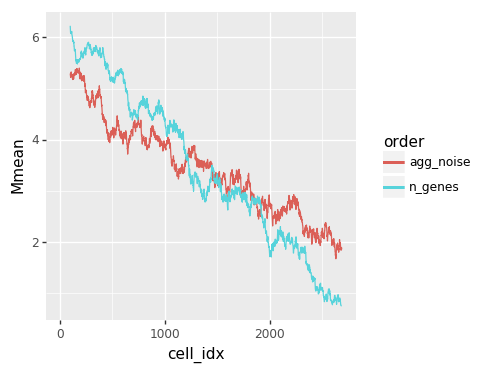

<ggplot: (8743920024100)>


In [26]:
# refactor plot
gene = 'RETSAT'
window=100
plot_df = pd.DataFrame()
for feature in ['agg_noise','n_genes']:
    
    slice_df = (gene_df
           .loc[:,[gene] + [feature]]
              )
    if feature == 'n_genes':
        ascending_order = False
    else:
        ascending_order = True
    slice_df = slice_df.sort_values(feature, ascending=ascending_order).rename(columns = {feature:'Mmean'})
    slice_df['Mmean'] = slice_df[gene].rolling(window).mean()
    slice_df['cell_idx'] = [x for x in range(len(slice_df))]
    slice_df['order'] = feature
    plot_df = plot_df.append(slice_df)

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      +geom_line(aes('cell_idx','Mmean', color = 'order'))
     )

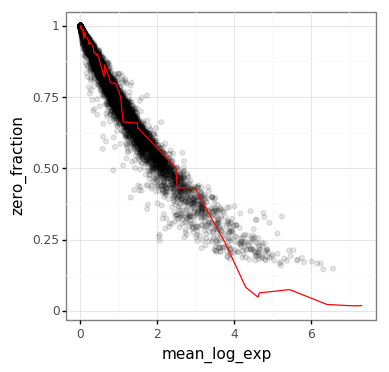

<ggplot: (8743947379734)>


In [10]:
# determine the background level of dropout looking at ERCC zero counts vs mean log expression
ercc_raw = pre_adata.apply(lambda x: np.log(x+1))
dropout_df = pd.DataFrame()
dropout_df['mean_log_exp'] = ercc_raw.mean(axis =1)
dropout_df['non_zero_count'] = ercc_raw.apply(np.count_nonzero, axis = 1)
dropout_df['zero_fraction'] = (len(ercc_raw.columns)-dropout_df['non_zero_count']) / len(ercc_raw.columns)
dropout_df['gene'] = pre_adata.index.tolist()
dropout_df['ercc'] = [x.startswith('ERCC-') for x in pre_adata.index]

print(ggplot()
     +theme_bw()
     +geom_point(dropout_df[dropout_df.ercc == False], aes('mean_log_exp', 'zero_fraction'), alpha = 0.1)
     +geom_line(dropout_df[dropout_df.ercc == True], aes('mean_log_exp', 'zero_fraction'), color='red')
     )

# the relationship between zero_fraction and mean_log_expression is bimodal, with a change in slop around mean log 3

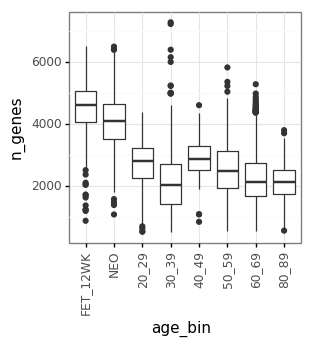

<ggplot: (-9223363292907395987)>


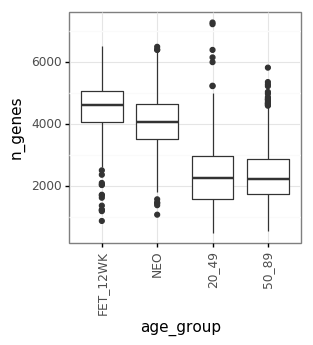

<ggplot: (-9223363292907395994)>


In [11]:
# n_genes across all ages
input_adata = adata_subset2

plot_df = input_adata.obs.loc[:,['age', 'age_bin', 'age_group', 'n_genes']]
plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
     + theme_bw()
     + theme(axis_text_x = element_text(angle = 90))
     + geom_boxplot(aes('age_bin','n_genes'))
     )
print(ggplot(plot_df)
     + theme_bw()
     + theme(axis_text_x = element_text(angle = 90))
     + geom_boxplot(aes('age_group','n_genes'))
     )